In [4]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
print("Done!")
import sys
sys.path.append("..")

print("Done!")


Done!
Done!


In [18]:
from numpy import binary_repr
binary_repr(20, width=16)

s = "12345"
print(s[1:-1])

234


In [5]:

class BasicDerivativeEnv(object):
    
    def __init__(self, phi, phidot):
        self.phi = phi
        self.phidot = phidot
        self.phis = []
        self.phidots = []
        
    def step(self):
        self.phi += self.phidot
        #print(self.phi)
        self.phis.append(np.sum(self.phi))
        self.phidots.append(np.sum(self.phidot))
        return np.array([self.phi, self.phidot])
    
    def nullstep(self):
        self.phis.append(np.sum(self.phi))
        self.phidots.append(np.sum(self.phidot))
        return np.array([self.phi, self.phidot])
    
    def start(self):
        return np.array([self.phi, self.phidot])
    
    
class DynamicalLayer(object):
    
    def __init__(self, hierarchical_bottom_up_dimension, layer_dimension, dynamical_top_down_dimension, learning_rate=0.01, input_layer=False):
        self.hierarchical_bottom_up_dimension = hierarchical_bottom_up_dimension
        self.layer_dimension = layer_dimension
        self.dynamical_top_down_dimension = dynamical_top_down_dimension
        self.mu = np.random.normal(0, 0.05, [layer_dimension,1])
        self.sensory_weights = np.random.normal(0,0.05, [hierarchical_bottom_up_dimension, layer_dimension])
        self.dynamical_weights = np.random.normal(0,0.05, [dynamical_top_down_dimension, layer_dimension])
        self.mus = []
        self.ezs= []
        self.ews = []
        self.thetaws = []
        self.thetazs = []
        self.sensory_pe = np.random.normal(0,0.5, [layer_dimension,1])
        self.dynamical_pe = np.random.normal(0,0.5, [dynamical_top_down_dimension,1])
        self.learning_rate = learning_rate
        self.input_layer = input_layer
    
    def run(self, bu_dynamical_pe, bu_hierarchical_pe, td_mu,td_pred, learning=False):
        bu_hierarchical_pe = np.reshape(bu_hierarchical_pe, (len(bu_hierarchical_pe),1))
        if self.input_layer:
            #print(bu_hierarchical_pe)
            self.mu = bu_hierarchical_pe
            #print(self.mu.shape)
            #print(td_mu.shape)
            self.sensory_pe = self.mu - td_pred
            #print(self.sensory_pe.shape)
           # self.dynamical_pe = td_mu - np.dot(self.dynamical_weights, self.mu)
            if td_mu is None:
                self.dynamical_pe = 0
            else:
                self.dynamical_pe = np.zeros([len(td_mu),1])
            #print(self.dynamical_pe.shape)
            pred= td_pred 

            
            
        else:
            if td_pred is None:
                self.sensory_pe = np.zeros([len(self.mu),1])
            else:
                self.sensory_pe = self.mu - td_pred
            if td_mu is None:
                self.dynamical_pe = np.zeros([self.dynamical_top_down_dimension,1])
            else:
                self.dynamical_pe = td_mu - np.dot(self.dynamical_weights, self.mu)
            mugrad = self.sensory_pe + bu_dynamical_pe + np.dot(self.sensory_weights.T, bu_hierarchical_pe) + np.dot(self.dynamical_weights.T, self.dynamical_pe)
            self.mu += (self.learning_rate * mugrad)
            if learning:
                thetazgrad = np.dot(bu_hierarchical_pe, self.mu.T)
                thetawgrad = np.dot(self.dynamical_pe, self.mu.T)
                self.sensory_weights += (self.learning_rate * thetazgrad)
                self.dynamical_weights += (self.learning_rate * thetawgrad)

            pred = np.dot(self.sensory_weights, self.mu)
            # and do the basic logging!
        self.mus.append(np.sum(self.mu))
        self.ews.append(np.sum(self.dynamical_pe))
        self.ezs.append(np.sum(self.sensory_pe))
        self.thetaws.append(np.sum(self.dynamical_weights))
        self.thetazs.append(np.sum(self.sensory_weights))
        return self.sensory_pe, self.dynamical_pe, self.mu, pred
        
    def plot(self,N,i,j):
        print("Layer " + str(i) + "Dynamical " + str(j))
        print("Mus")
        plt.plot(N, self.mus)
        plt.show()
        print("Sensory PEs")
        plt.plot(N, self.ezs)
        plt.show()
        print("Dynamical PEs")
        plt.plot(N, self.ews)
        plt.show()
        print("Sensory Weights")
        plt.plot(N, self.thetazs)
        plt.show()
        print("Dynamical Weights")
        plt.plot(N, self.thetaws)
        plt.show()
        
    
class HierarchicalLayer(object):
    
    def __init__(self, dynamical_order, input_dimensions, layer_dimensions, learning_rate=0.01, input_layer=False):
        # assumes input dimensions and layer dimensions of the same length as the dynamical dimensions
        self.dynamical_order = dynamical_order
        self.input_dimensions = input_dimensions
        self.layer_dimensions = layer_dimensions
        self.layer_dimensions.append(1) #
        self.learning_rate = learning_rate
        self.input_layer = input_layer
        self.dynamical_layers = []
        self.wps = []
        self.wpes = []
        self.wpes.append(np.zeros([layer_dimensions[0],1]))
        for i in range(dynamical_order):
            # these are the dynamics!
            l = DynamicalLayer(self.input_dimensions[i], self.layer_dimensions[i], self.layer_dimensions[i+1], self.learning_rate, self.input_layer)
            self.dynamical_layers.append(l)
            self.wps.append(l.mu)
            self.wpes.append(l.mu)
        #self.wps.append(np.zeros([self.layer_dimensions[-1],1]))
        self.wps.append(None)
    def run(self, pes, preds, learning):
        ezs = []
        ps = []
        for i, layer in enumerate(self.dynamical_layers):
            #print(len(self.wps))
            #print(i)
            ez, ep, mu, pred = layer.run(self.wpes[i], pes[i],self.wps[i+1], preds[i], learning)
            ezs.append(ez)
            ps.append(pred)
            self.wps[i]= mu
            self.wpes[i+1] = ep
        return ezs, ps
            

class Model(object):
    
    def __init__(self, env, epochs, inference_runs):
            self.env = env
            self.epochs = epochs
            self.inference_runs = inference_runs
            self.N = self.epochs * self.inference_runs
            self.layers = []
            self.ps = [0]
            self.pes =[]
            self.preds = []
            self.prediction_errors = []
            self.phis = self.env.start()
            self.initialized = False
            
    def add(self, layer):
        self.layers.append(layer)
    
    def initialize(self):
        for i, layer in enumerate(self.layers):
            pe = []
            p = []
            for j, d_layer in enumerate(layer.dynamical_layers):
                p.append(np.zeros([d_layer.layer_dimension,1]))
                pe.append(np.zeros([d_layer.layer_dimension,1]))
            pe.append(None) # I hope this works!
            self.ps.append(p)
            self.pes.append(pe)
            self.preds.append([])
            self.prediction_errors.append([])
        self.pes.append(None)
        self.initialized = True
        return
    
    def train(self):
        if not self.initialized:
            self.initialize()
            
        for i in range(self.N):
            if i % self.inference_runs == 0:
                self.phis = self.env.step()
            else:
                self.phis = self.env.nullstep()
            self.pes[0] = self.phis
            for j, layer in enumerate(self.layers):
                if i % self.inference_runs == 0:
                    pe, p = layer.run(self.pes[j], self.ps[j+1], learning = True)
                else:
                    pe, p = layer.run(self.pes[j], self.ps[j+1],learning=False)
                self.pes[j+1] = pe
                self.ps[j] = p
                self.preds[j].append(np.sum(p))
                self.prediction_errors[j].append(np.sum(pe))
                # add random noise to top layer
                #self.ps[j+1] = [np.random.normal(0, 0.05, [ld,1]) for ld in layer.layer_dimensions]
                self.ps[j+1] = [None for _ in layer.layer_dimensions]
        return 
    
    def plot(self):
        print("Env Phis")
        plt.plot(range(self.N), env.phis)
        plt.show()
        print("Env Phidots")
        plt.plot(range(self.N), env.phidots)
        plt.show()
        for i, layer in enumerate(self.layers):
            for j, d_layer in enumerate(layer.dynamical_layers):
                d_layer.plot(range(self.N), i,j)
        for k,pred in enumerate(self.preds):
            print("Prediction of layer : " + str(k))
            plt.plot(range(self.N), pred)
            plt.show()
        return
    
        
        
print("Done!")


Done!


In [10]:
class SineWaveEnv():
    
    def __init__(self, f):
        self.f = f
        self.N = 0
        
    def start(self):
        return self.step()
        
    def step(self):
        self.N +=1
        return [np.sin(self.N/self.f), np.cos(self.N/self.f), -np.sin(self.N/self.f)]

In [12]:
env = SineWaveEnv(1000)
m = Model(env, 100, 100)
m.add(HierarchicalLayer(3, [1,1],[1,1], input_layer=True))
m.add(HierarchicalLayer(3, [1,1],[1,1]))
m.initialize()
m.train()
print("Done!")
m.plot()

IndexError: list index out of range

Done
Env Phis


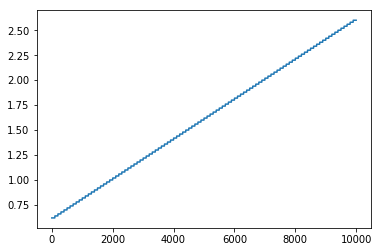

Env Phidots


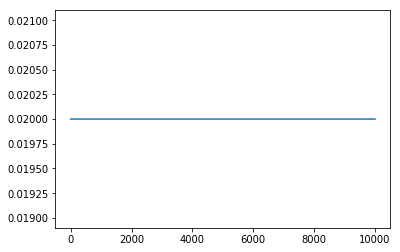

Layer 0Dynamical 0
Mus


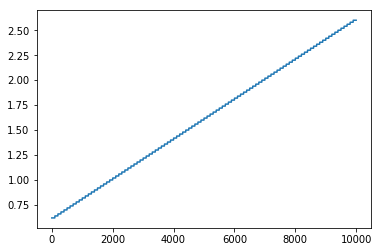

Sensory PEs


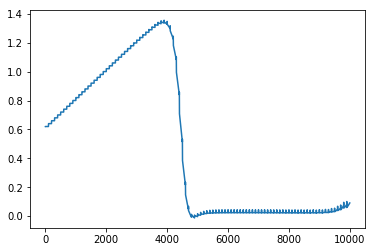

Dynamical PEs


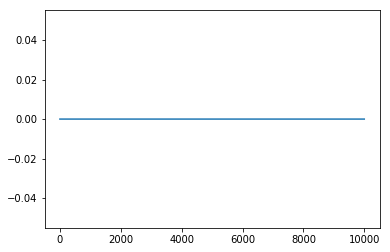

Sensory Weights


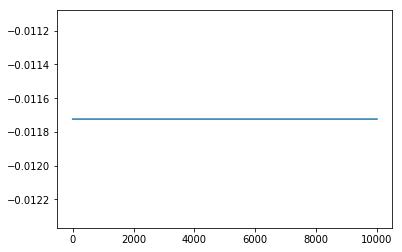

Dynamical Weights


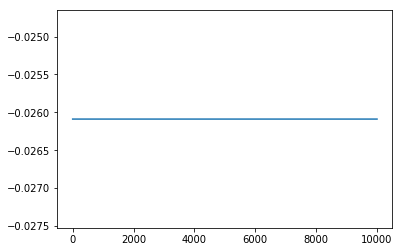

Layer 0Dynamical 1
Mus


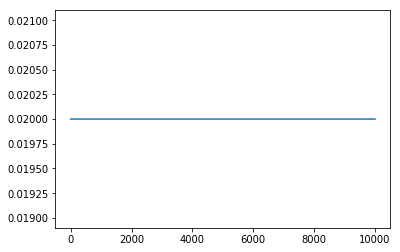

Sensory PEs


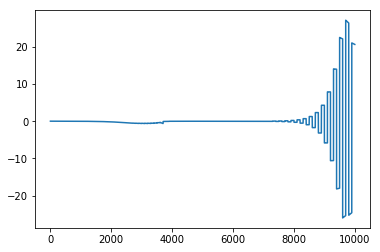

Dynamical PEs


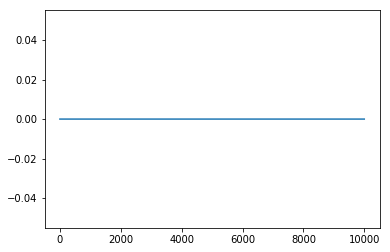

Sensory Weights


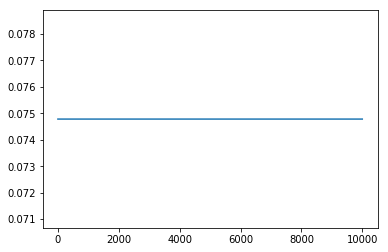

Dynamical Weights


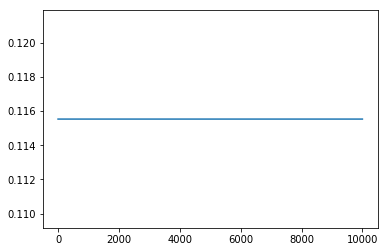

Layer 1Dynamical 0
Mus


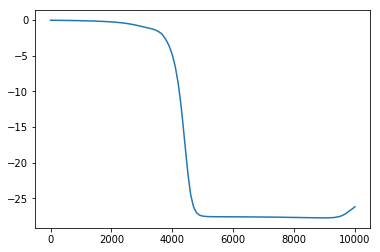

Sensory PEs


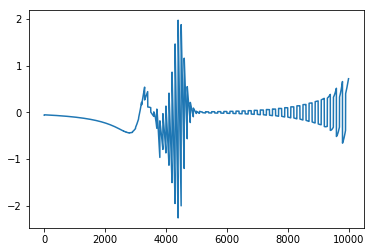

Dynamical PEs


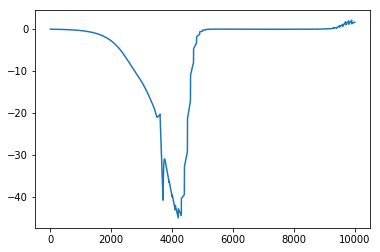

Sensory Weights


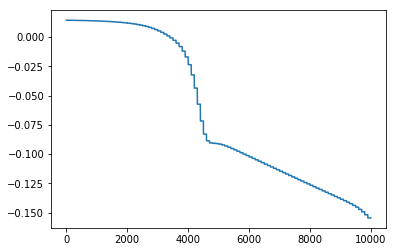

Dynamical Weights


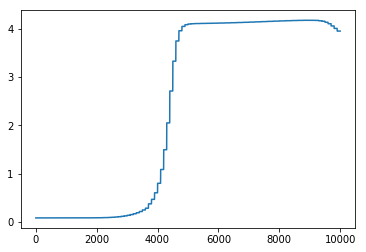

Layer 1Dynamical 1
Mus


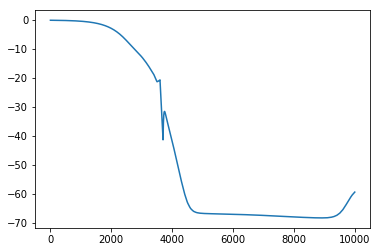

Sensory PEs


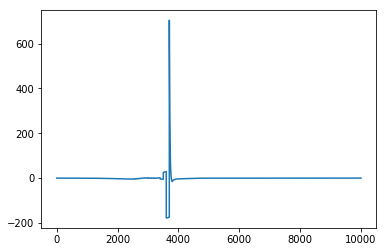

Dynamical PEs


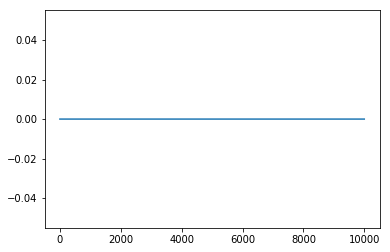

Sensory Weights


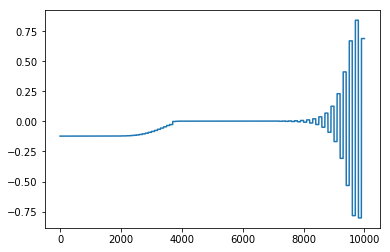

Dynamical Weights


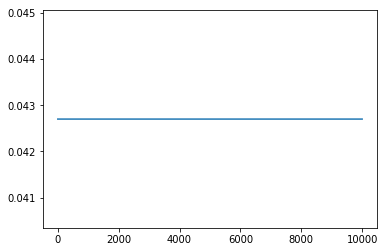

Layer 2Dynamical 0
Mus


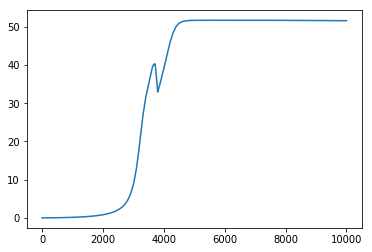

Sensory PEs


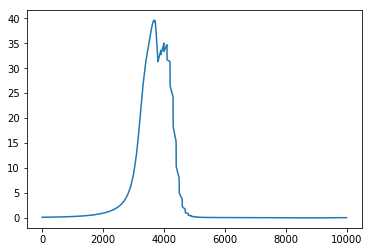

Dynamical PEs


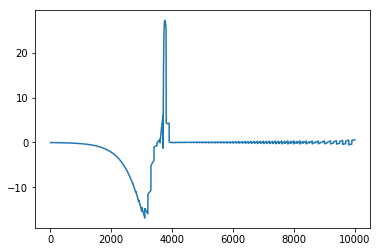

Sensory Weights


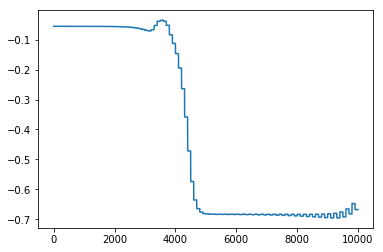

Dynamical Weights


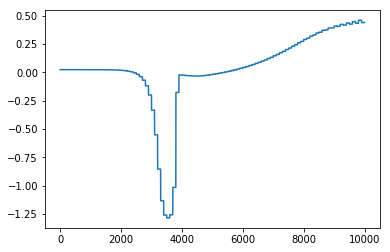

Layer 2Dynamical 1
Mus


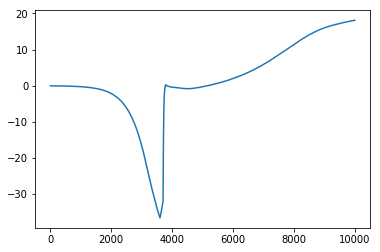

Sensory PEs


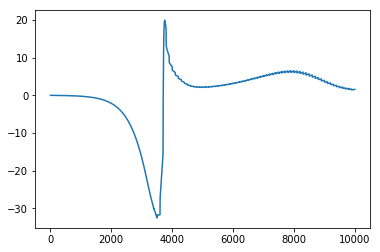

Dynamical PEs


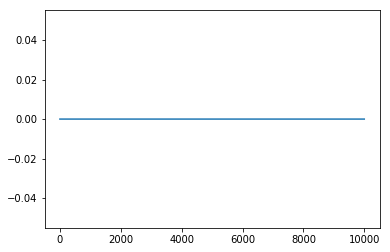

Sensory Weights


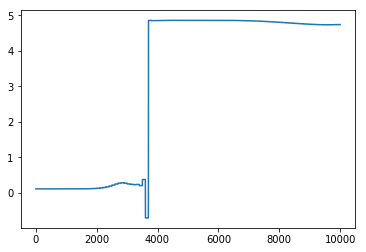

Dynamical Weights


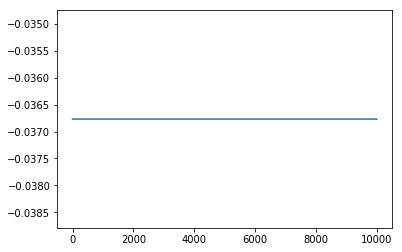

Layer 3Dynamical 0
Mus


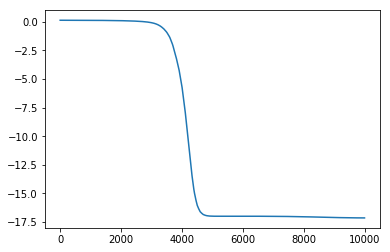

Sensory PEs


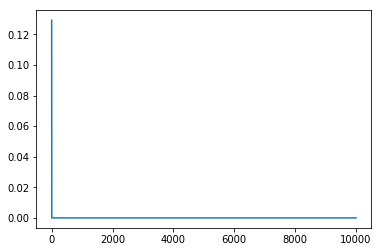

Dynamical PEs


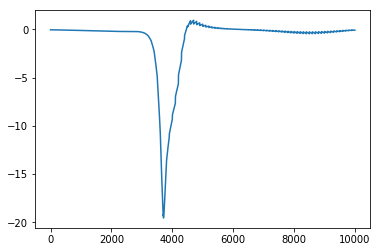

Sensory Weights


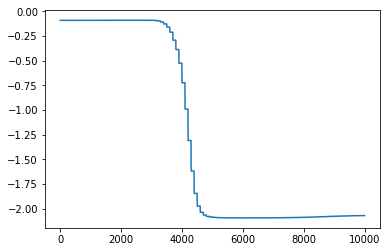

Dynamical Weights


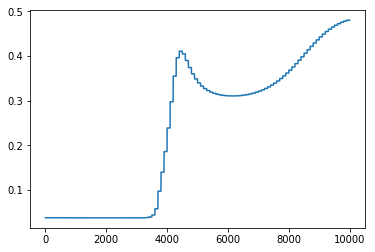

Layer 3Dynamical 1
Mus


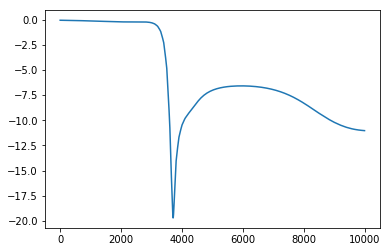

Sensory PEs


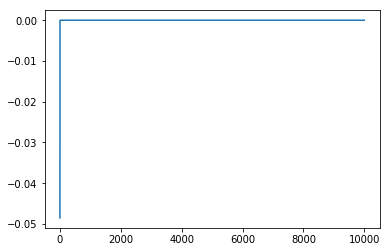

Dynamical PEs


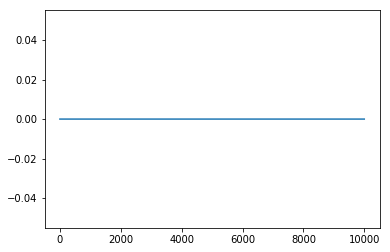

Sensory Weights


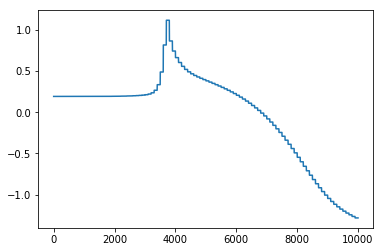

Dynamical Weights


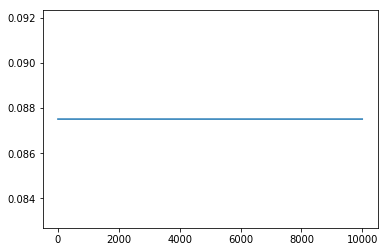

Prediction of layer : 0


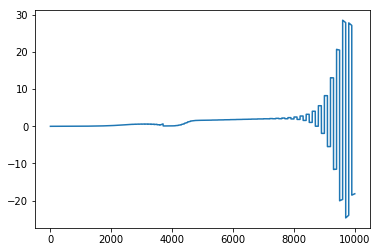

Prediction of layer : 1


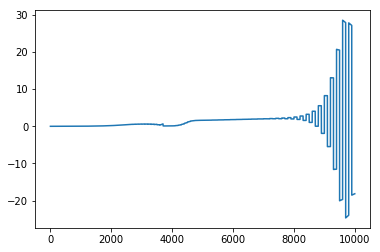

Prediction of layer : 2


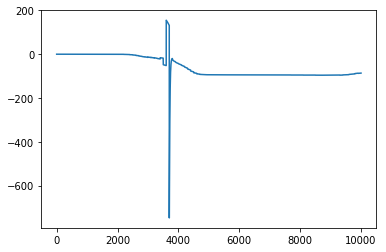

Prediction of layer : 3


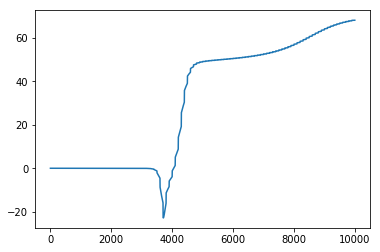

In [22]:
env = BasicDerivativeEnv(np.array([0.1,0.5]), np.array([0.01, 0.01]))
m = Model(env,100,100)
m.add(HierarchicalLayer(2, [2,2],[2,2],learning_rate = 0.001, input_layer=True))
m.add(HierarchicalLayer(2,[2,2],[2,2], learning_rate = 0.001))
m.add(HierarchicalLayer(2,[2,2],[2,2], learning_rate = 0.001))
m.add(HierarchicalLayer(2,[2,2],[2,2], learning_rate = 0.001))
m.initialize()
m.train()
print("Done")
m.plot()

Phi


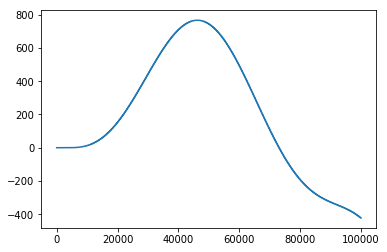

Phidot


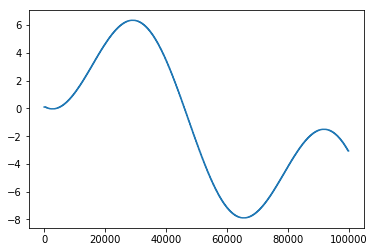

Phidotdot


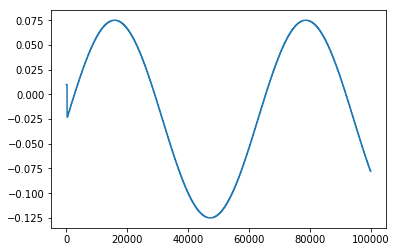

mu10


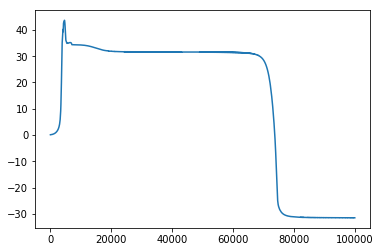

mu11


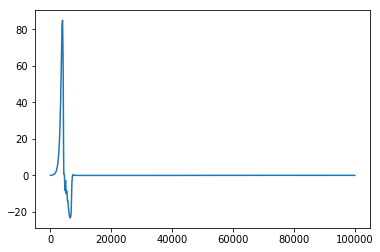

mu12


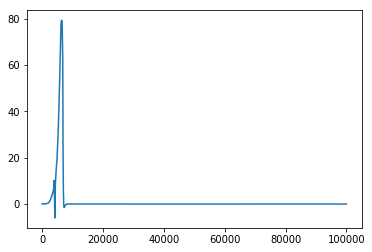

mu20


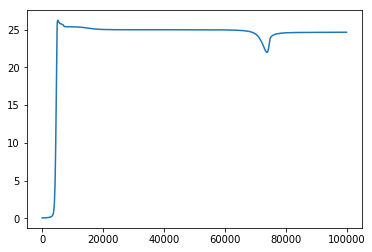

mu21


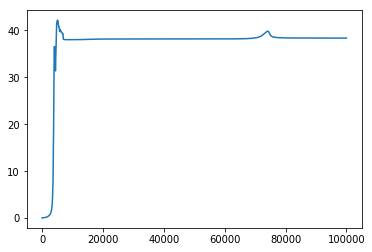

mu22


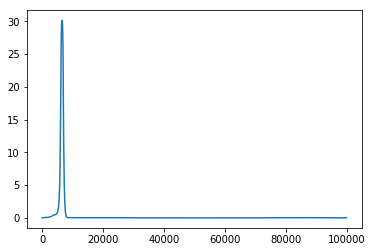

ez00


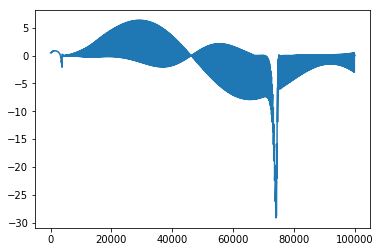

ez01


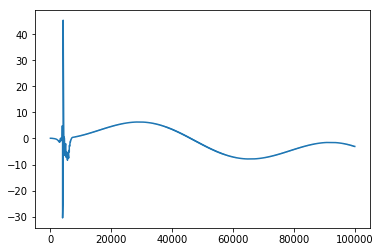

ez02


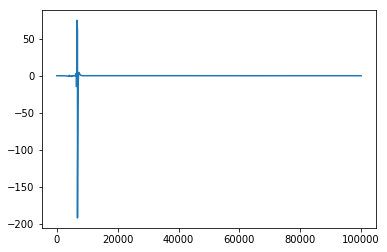

ez10


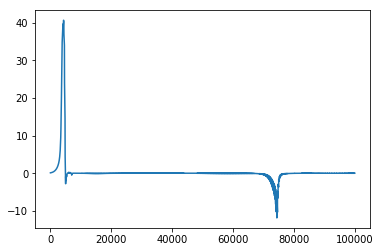

ez11


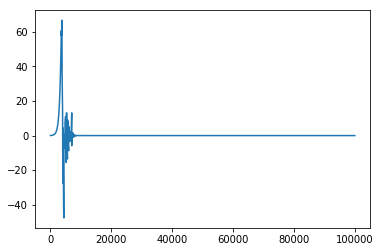

ez12


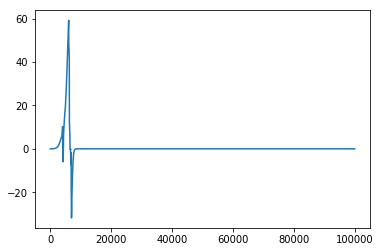

ew11


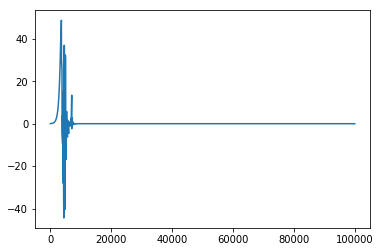

ew12


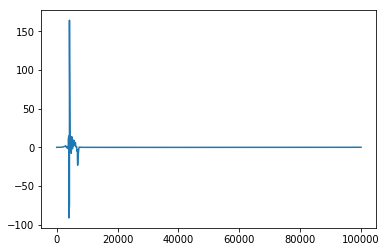

ew21


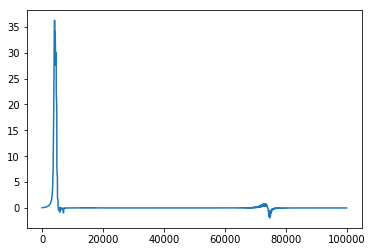

ew22


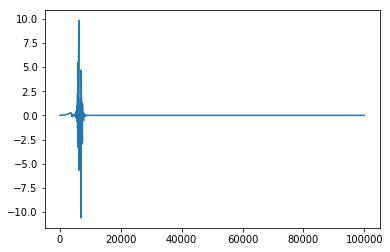

wz10


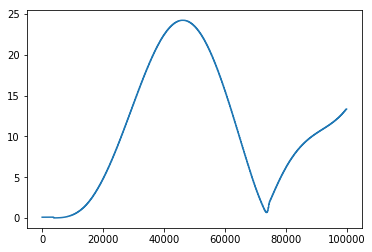

wz11


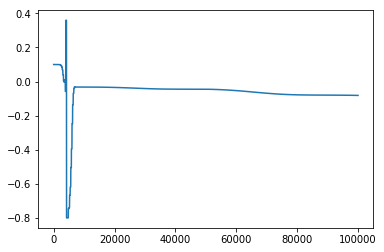

wz12


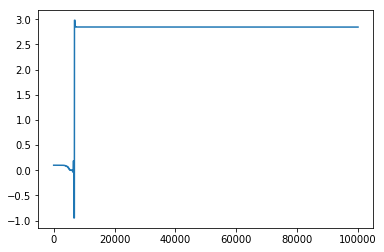

wz20


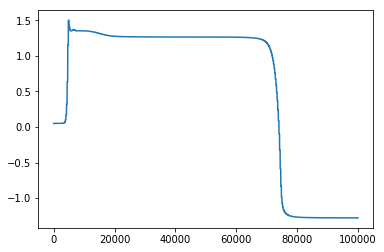

wz21


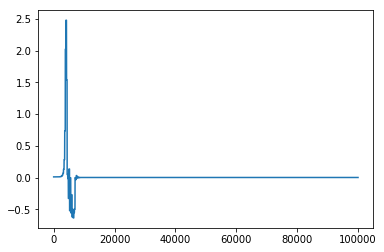

wz22


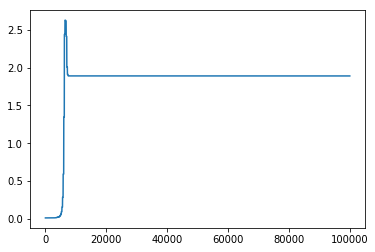

ww11


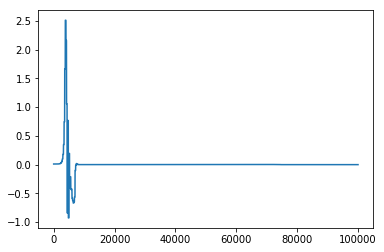

ww12


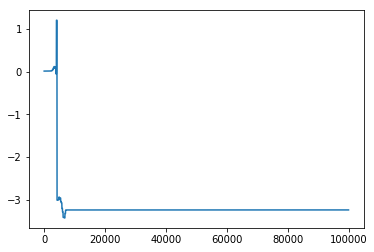

ww21


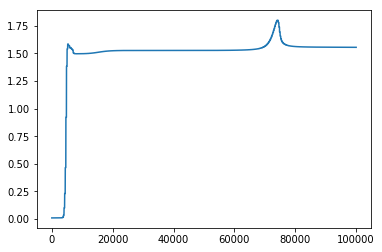

ww22


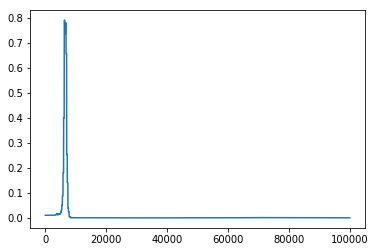

pred0


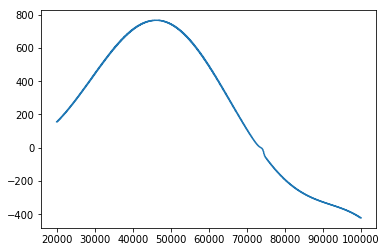

pred1


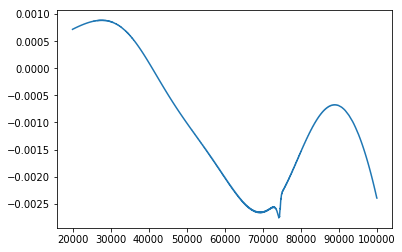

pred2


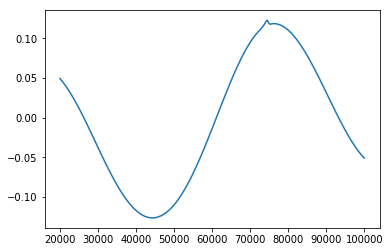

In [224]:

epochs = 500
inference_num = 200

hidden = 1
phi = [0.5]
phidot = [0.1]
phidotdot = [0.01]

mu00 = [phi[0]]
mu01 = [phidot[0]]
mu02 = [phidotdot[0]]
mu10 = [0.1]
mu11 = [0.05]
mu12 = [0.01]
mu20 = [0.05]
mu21 = [0.05]
mu22 = [0.01]
wz01 = [0.2]
wz10 = [0.1]
wz11 = [0.1]
wz12 = [0.1]
ww00 = [0.05]
ww01 = [0.05]
ww10 = [0.05]
wz20 = [0.05]
wz21 = [0.01]
wz22 = [0.01]
ww21 = [0.01]
ww11 = [0.01]
ww12 = [0.01]
ww22 = [0.01]

ez00 = [mu00[0] - (wz10[0] * mu10[0])]
ez01 = [mu01[0] - (wz11[0] * mu11[0])]
ez02 = [mu02[0] - (wz12[0] * mu12[0])]

ez10 = [mu10[0] - (wz20[0] * mu20[0])]
ez11 = [mu11[0] - (wz21[0] * mu21[0])]
ez12 = [mu12[0] - (wz22[0] * mu22[0])]

ew11 = [mu11[0] - (ww10[0] * mu10[0])]
ew12 = [mu12[0] - (ww12[0] * mu11[0])]

ew21 = [mu20[0] - (ww21[0] * mu20[0])]
ew22 = [mu22[0] - (ww22[0] * mu21[0])]

pred0 = [0]
pred1 = [0]
pred2 = [0]


learning_rate = 0.001

for i in range(1,epochs * inference_num):
    if i % inference_num == 0:
        phi.append(phi[i-1] + phidot[i-1])
        phidot.append(phidot[i-1] + phidotdot[i-1])
        phidotdot.append(0.1 * (np.sin(i/10000) - 0.25))
    else:
        phi.append(phi[i-1])
        phidot.append(phidot[i-1])
        phidotdot.append(phidotdot[i-1])
    
   # if i % 20000 == 0:
    #    hidden = -1 * hidden
    
    mu00.append(phi[i])
    mu01.append(phidot[i])
    mu02.append(phidotdot[i])
    
    ez00.append(mu00[i] - (wz10[i-1] * mu10[i-1]))
    ez01.append(mu01[i] - (wz11[i-1] * mu11[i-1]))
    ez02.append(mu02[i] - (wz12[i-1] * mu12[i-1]))
    
    ez10.append(mu10[i-1] - (wz20[i-1] * mu20[i-1]))
    ez11.append(mu11[i-1] - (wz21[i-1] * mu21[i-1]))
    ez12.append(mu12[i-1] - (wz22[i-1] * mu22[i-1]))
    
    ew11.append(mu11[i-1] - (ww11[i-1] * mu10[i-1]))  
    ew12.append(mu12[i-1] - (ww12[i-1] * mu11[i-1]))
    ew21.append(mu21[i-1] - (ww21[i-1] * mu20[i-1]))
    ew22.append(mu22[i-1] - (ww22[i-1] * mu21[i-1]))
    
    mu10grad = (ez00[i] * wz10[i-1]) + (ew11[i] * ww11[i-1]) + ez10[i]
    mu11grad = (ez01[i] * wz11[i-1]) + (ew12[i] *ww12[i-1]) + ew11[i] + ez11[i]
    mu12grad =  (ez02[i] * wz12[i-1]) + ez12[i] + ew12[i]
    
    mu20grad = (ez10[i] * wz20[i-1]) + (ew21[i] * ww21[i-1])
    #print(i)
    #print(len(ez11))
    #print(len(wz21))
    ##print(len(ez21))
    #print(len(ew22))
    #print(len(ww22))
    mu21grad = (ez11[i] * wz21[i-1]) + ew21[i] + (ew22[i]* ww22[i-1])
    mu22grad = (ez12[i] * wz22[i-1]) + ew22[i]

    
    mu10.append(mu10[i-1] + (learning_rate * mu10grad))
    mu11.append(mu11[i-1] + (learning_rate * mu11grad))
    mu12.append(mu12[i-1] + (learning_rate * mu12grad))
    mu20.append(mu20[i-1] + (learning_rate * mu20grad))
    mu21.append(mu21[i-1] + (learning_rate * mu21grad))
    mu22.append(mu22[i-1] + (learning_rate * mu22grad))
    
    

    # update the weights
    if i % inference_num == 0:
        wz10.append(wz10[i-1] + (learning_rate * ez00[i] * mu10[i]))
        wz11.append(wz11[i-1] + (learning_rate * ez01[i] * mu11[i]))
        wz12.append(wz12[i-1] + (learning_rate * ez02[i] * mu12[i]))
        wz20.append(wz20[i-1] + (learning_rate * ez10[i] * mu20[i]))
        wz21.append(wz21[i-1] + (learning_rate * ez11[i] * mu21[i]))
        wz22.append(wz22[i-1] + (learning_rate * ez12[i] * mu22[i]))
        
        
        ww11.append(ww11[i-1] + (learning_rate * ew11[i] * mu10[i]))
        ww12.append(ww12[i-1] + (learning_rate * ew12[i] * mu11[i]))
        ww21.append(ww21[i-1] + (learning_rate * ew21[i] * mu20[i]))
        ww22.append(ww22[i-1] + (learning_rate  *ew22[i] * mu21[i]))
    else:
        wz10.append(wz10[i-1])
        wz11.append(wz11[i-1])
        wz12.append(wz12[i-1])
        wz20.append(wz20[i-1])
        wz21.append(wz21[i-1])
        wz22.append(wz22[i-1])
        
        ww11.append(ww11[i-1])
        ww12.append(ww12[i-1])
        ww21.append(ww21[i-1])
        ww22.append(ww22[i-1])
    
    pred0.append(wz10[i] * mu10[i])
    pred1.append(wz11[i] * mu11[i])
    pred2.append(wz12[i] * mu12[i])

n  = range(epochs * inference_num)
print("Phi")
plt.plot(n, phi)
plt.show()
print("Phidot")
plt.plot(n, phidot)
plt.show()
print("Phidotdot")
plt.plot(n, phidotdot)
plt.show()
print("mu10")
plt.plot(n, mu10)
plt.show()
print("mu11")
plt.plot(n, mu11)
plt.show()
print("mu12")
plt.plot(n, mu12)
plt.show()
print("mu20")
plt.plot(n, mu20)
plt.show()
print("mu21")
plt.plot(n, mu21)
plt.show()
print("mu22")
plt.plot(n, mu22)
plt.show()
print("ez00")
plt.plot(n, ez00)
plt.show()
print("ez01")
plt.plot(n, ez01)
plt.show()
print("ez02")
plt.plot(n, ez02)
plt.show()
print("ez10")
plt.plot(n, ez10)
plt.show()
print("ez11")
plt.plot(n, ez11)
plt.show()
print("ez12")
plt.plot(n, ez12)
plt.show()
print("ew11")
plt.plot(n, ew11)
plt.show()
print("ew12")
plt.plot(n, ew12)
plt.show()
print("ew21")
plt.plot(n, ew21)
plt.show()
print("ew22")
plt.plot(n, ew22)
plt.show()

print("wz10")
plt.plot(n, wz10)
plt.show()
print("wz11")
plt.plot(n, wz11)
plt.show()
print("wz12")
plt.plot(n, wz12)
plt.show()
print("wz20")
plt.plot(n, wz20)
plt.show()
print("wz21")
plt.plot(n, wz21)
plt.show()
print("wz22")
plt.plot(n, wz22)
plt.show()
print("ww11")
plt.plot(n, ww11)
plt.show()
print("ww12")
plt.plot(n, ww12)
plt.show()
print("ww21")
plt.plot(n, ww21)
plt.show()
print("ww22")
plt.plot(n, ww22)
plt.show()
print("pred0")
plt.plot(n[20000:], pred0[20000:])
plt.show()
print("pred1")
plt.plot(n[20000:], pred1[20000:])
plt.show()
print("pred2")
plt.plot(n[20000:], pred2[20000:])
plt.show()